In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import datetime
import itertools

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
# https://www.youtube.com/watch?v=EgIU1_qZ5Lcabs

In [3]:
# read in data from csv and convert column names to str
df100 = pd.read_csv('tfrrs_top24.csv')

In [4]:
# keep only running events
running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '110H', '400H', '3000S', '4x100', '4x400']
df100 = df100[df100['EVENT'].isin(running_events)]

### For each unique combination of DIVISION/EVENT/SEX group all years together.

In [146]:
# separate df into 2021 and non 2021 years
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100 = df100[df100['CHAMP_YEAR'] != 2021]

In [147]:
def regroup_df(df):
    '''group by CHAMP_YEAR DIVISION EVENT SEX'''
    df_group = df.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']).mean()
    group = df_group['TIME_SECS'].groupby(['EVENT', 'DIVISION'], group_keys=False)
    res = group.apply(lambda x: x.sort_values(ascending=[False]))
    
    return pd.DataFrame(res).reset_index()

In [148]:
regroup = regroup_df(df100)

In [149]:
regroup2021 = regroup_df(df100_2021)

### Regression for time trends

In [66]:
# functions to get the slope, coef of determination, pvalue and std errors for two arrays
def reg_slope(X,y):
    '''Return stats.linregress slope for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[0]

def reg_rval(X,y):
    '''Return stats.linregress p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[2]

def reg_pval(X,y):
    '''Return stats.linregress p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[3]

def reg_stderr(X,y):
    '''Return stats.linregress standard error for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[4]

In [186]:
def reg_table(df):
    '''Take top 10 rows of dataframe: regress TIME_SECS on CHAMP_YEAR, predict 2021 and save the results to new df.'''
    results_list = []
    while len(df) > 0:
        
        years = [df.CHAMP_YEAR[i] for i in range(10)]
        means = [df.TIME_SECS[i] for i in range(10)]
        
        slope = reg_slope(years,means)
        rval = reg_rval(years,means)
        pval = reg_pval(years,means)
        std_err = reg_stderr(years,means)
        
        X = np.array(years).reshape(-1, 1)
        y = means

        reg = LinearRegression().fit(X, y)
        pred = reg.predict(np.array(2021).reshape(-1,1))[0]
        
        

        row_result = [str(df.DIVISION[0]), str(df.SEX[0]), str(df.EVENT[0]), slope, rval, pval, means_std, std_err, pred]
        results_list.append(row_result)
        
        df = df.drop(range(0,10))
        df = df.reset_index(drop=True)
    return pd.DataFrame(results_list, columns=['DIVISION', 'SEX', 'EVENT', 'SLOPE', 'R_VAL','P_VAL', 'MEANS_STD', 'STD_ERR', '2021_PRED'])

In [206]:
def pred_interval(means_list, prediction, critical_value = 1.96):
    sum_errs = arraysum((y - yhat)**2)
    stdev = sqrt(1/(len(y)-2) * sum_errs)

In [210]:
stdev = np.sqrt(1/(len(means)-2) * sum_errs)

In [213]:
sum_errs

0.1232028219655546

In [214]:
stdev

0.12409815770467475

In [ ]:
sum_errs = arraysum((y - yhat)**2)
stdev = sqrt(1/(len(y)-2) * sum_errs)

In [187]:
regression_df = reg_table(regroup)

In [189]:
regression_df.head()

,DIVISION,SEX,EVENT,SLOPE,R_VAL,P_VAL,MEANS_STD,STD_ERR,2021_PRED
0,D1,Women,100,-0.014371,-0.688509,0.027701,0.063196,0.005352,11.102879
1,D1,Men,100,-0.010641,-0.692619,0.026414,0.046517,0.003918,10.056831
2,D2,Women,100,-0.011783,-0.756616,0.011307,0.047150,0.003600,11.608745
3,D2,Men,100,-0.011157,-0.797487,0.005717,0.042356,0.002984,10.318399
4,D3,Women,100,-0.011470,-0.551365,0.098512,0.062982,0.006136,11.942197


In [69]:
regression_df['2021_ACTUAL'] = regroup2021['TIME_SECS']

In [70]:
regression_df['PERCENT_DIFF'] = ((regression_df['2021_ACTUAL'] - regression_df['2021_PRED']) / regression_df['2021_PRED'])*100

In [170]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    #generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [ ]:
get_prediction_interval

In [ ]:
regression_df['CI_99']

In [159]:
regression_df.head()

,DIVISION,SEX,EVENT,SLOPE,R_VAL,P_VAL,STD_ERR,2021_PRED,2021_ACTUAL,PERCENT_DIFF
0,D1,Women,100,-0.014371,-0.688509,0.027701,0.005352,11.102879,11.149583,0.420653
1,D1,Men,100,-0.010641,-0.692619,0.026414,0.003918,10.056831,10.066667,0.097803
2,D2,Women,100,-0.011783,-0.756616,0.011307,0.003600,11.608745,11.606667,-0.017903
3,D2,Men,100,-0.011157,-0.797487,0.005717,0.002984,10.318399,10.389583,0.689878
4,D3,Women,100,-0.011470,-0.551365,0.098512,0.006136,11.942197,12.016250,0.620096


In [71]:
# write to csv
# regression_df.to_csv('trends_table.csv', index=False)

### Group by distance/sprint and run KS-test to see if slopes are statistically different.

In [72]:
distance_events = ['800', '10000', '1500', '3000S','5000']
regression_df_distance = regression_df.loc[regression_df['EVENT'].isin(distance_events)]
regression_df_sprint = regression_df.loc[~regression_df['EVENT'].isin(distance_events)]

In [73]:
len(regression_df_distance)

24

In [74]:
len(regression_df_sprint)

48

In [75]:
distance_slope = regression_df_distance.SLOPE
sprint_slope = regression_df_sprint.SLOPE

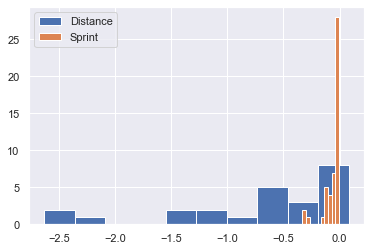

In [76]:
fig, ax = plt.subplots()
ax.hist(distance_slope, label='Distance')
ax.hist(sprint_slope, label='Sprint')
ax.legend(loc='upper left')
plt.show()

In [77]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

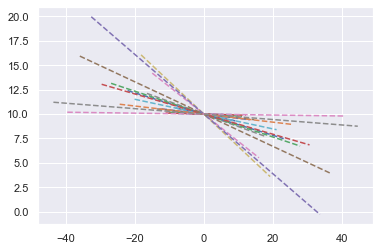

In [78]:
for i in sprint_slope:
    abline(i, 10)

In [79]:
regression_df.head()

,DIVISION,SEX,EVENT,SLOPE,R_VAL,P_VAL,STD_ERR,2021_PRED,2021_ACTUAL,PERCENT_DIFF
0,D1,Women,100,-0.014371,-0.688509,0.027701,0.005352,11.102879,11.149583,0.420653
1,D1,Men,100,-0.010641,-0.692619,0.026414,0.003918,10.056831,10.066667,0.097803
2,D2,Women,100,-0.011783,-0.756616,0.011307,0.003600,11.608745,11.606667,-0.017903
3,D2,Men,100,-0.011157,-0.797487,0.005717,0.002984,10.318399,10.389583,0.689878
4,D3,Women,100,-0.011470,-0.551365,0.098512,0.006136,11.942197,12.016250,0.620096


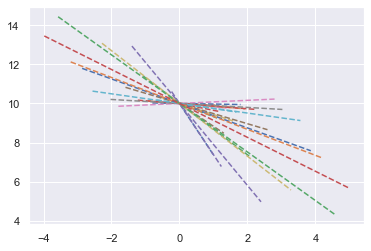

In [80]:
for i in distance_slope:
    abline(i, 10)

In [81]:
sprint_slope.describe()

count    48.000000
mean     -0.058373
std       0.075330
min      -0.333260
25%      -0.075956
50%      -0.026042
75%      -0.016242
max      -0.004280
Name: SLOPE, dtype: float64

In [82]:
distance_slope.describe()

count    24.000000
mean     -0.746398
std       0.787207
min      -2.631886
25%      -1.187177
50%      -0.542953
75%      -0.140278
max       0.079684
Name: SLOPE, dtype: float64

### Two Sample Kolmogorov-Smirnov test

In [83]:
# two random samples of half of the regression_df dataframe and perform a KS-2 Sample test
counter = 20
while counter > 0:
    print(ks_2samp(regression_df.SLOPE.sample(frac=0.5), regression_df.SLOPE.sample(frac=0.5)))
    counter -= 1

Ks_2sampResult(statistic=0.1388888888888889, pvalue=0.8514270592149538)
Ks_2sampResult(statistic=0.13888888888888895, pvalue=0.8514270592149535)
Ks_2sampResult(statistic=0.1111111111111111, pvalue=0.9713163247270222)
Ks_2sampResult(statistic=0.13888888888888895, pvalue=0.8514270592149535)
Ks_2sampResult(statistic=0.19444444444444448, pvalue=0.4602703537949784)
Ks_2sampResult(statistic=0.08333333333333337, pvalue=0.9993239969221616)
Ks_2sampResult(statistic=0.13888888888888884, pvalue=0.8514270592149542)
Ks_2sampResult(statistic=0.1388888888888889, pvalue=0.8514270592149538)
Ks_2sampResult(statistic=0.08333333333333337, pvalue=0.9993239969221616)
Ks_2sampResult(statistic=0.1111111111111111, pvalue=0.9713163247270222)
Ks_2sampResult(statistic=0.08333333333333326, pvalue=0.9993239969221616)
Ks_2sampResult(statistic=0.1388888888888889, pvalue=0.8514270592149538)
Ks_2sampResult(statistic=0.11111111111111116, pvalue=0.9713163247270221)
Ks_2sampResult(statistic=0.08333333333333337, pvalue=0.9

In [84]:
# Same test but for distance and sprint grouped sub-dfs
ks_2samp(sprint_slope, distance_slope)

Ks_2sampResult(statistic=0.75, pvalue=7.880861586304966e-09)

As you can see, KS tests with randomly selected sub-dfs from regression_df produce large p-values, fail to reject the null that they are the same distribution.  But running the KS test comparing distance and sprints the p-value is extremely small. Therefore, the prediction slopes for distance vs sprint events from 2010-2019 are not from the same distribution. 

### Feature Engineering

Create a new column TIME_SCALED so that we can compare changes across time between event division and sex by rescaling each groups times by the average time for that group using 2010 as the base year.  

In [85]:
# transform df100 from long to wide indexed by year and position.  Forward fill (ffill) to propagate nan values from tied position in original df
df100_wide = pd.pivot_table(df100, values=['TIME_SECS'], index=['CHAMP_YEAR', 'POSITION'], columns=['DIVISION', 'EVENT', 'SEX']).fillna(method='ffill')

In [86]:
# find the mean for each group in year 2010 for the base year
mean_2010 = [group for group in df100_wide.groupby('CHAMP_YEAR')][0][1].mean()

In [87]:
# divide each column in df100_wide by the mean_2010 series to get each TIME_SECS rescaled by the 2010 mean.
df100_rescaled = df100_wide.divide(mean_2010, axis=1)

In [88]:
# sort year high to low, position low to high
df100 = df100.sort_index(level=['CHAMP_YEAR', 'POSITION'], ascending=[False, True])

In [89]:
# new variable log of time_secs
df100['LOG_TIME_SECS'] = np.log(df100['TIME_SECS'])

In [90]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100['DIVISION'])
event_dummy = pd.get_dummies(df100['EVENT'])
sex_dummy = pd.get_dummies(df100['SEX'])

# distance event dummy
distance_events = ['800', '1500', '3000S', '5000', '10000']
df100['DISTANCE'] = [1 if event in distance_events else 0 for event in df100['EVENT']]

# concat dummy dfs to right side of df100_rescaled
df100 = pd.concat([df100, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

# treated dummy for years 2021 and after
df100['TREATED'] = df100[2021]

KeyError: 2021

In [92]:
# make sure column names are strings
df100.columns = df100.columns.astype(str)

In [93]:
df100 = df100.rename(columns={'2010': 'y2010', '2011': 'y2011', '2012': 'y2012', '2013': 'y2013', '2014': 'y2014', '2015': 'y2015',
       '2016': 'y2016', '2017': 'y2017', '2018': 'y2018', '2019': 'y2019', '2021': 'y2021', '100': 'e100', '10000': 'e10000', '100H': 'e100H', '110H': 'e110H', '1500': 'e1500', '200': 'e200', '3000S': 'e3000S', '400': 'e400', '400H': 'e400H',
       '4x100': 'e4x100', '4x400': 'e4x400', '5000': 'e5000', '800': 'e800'})

In [94]:
df100.columns

Index(['POSITION', 'CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX', 'ATHLETE', 'YEAR',
       'TEAM', 'TIME', 'TIME_SECS', 'MARK', 'CONV', 'POINTS', 'MEET',
       'MEET DATE', 'LOG_TIME_SECS', 'DISTANCE', 'y2010', 'y2011', 'y2012',
       'y2013', 'y2014', 'y2015', 'y2016', 'y2017', 'y2018', 'y2019', 'D1',
       'D2', 'D3', 'e100', 'e10000', 'e100H', 'e110H', 'e1500', 'e200',
       'e3000S', 'e400', 'e400H', 'e4x100', 'e4x400', 'e5000', 'e800', 'Men',
       'Women'],
      dtype='object')

In [95]:
# df100.drop(['DT', 'Dec', 'HJ', 'HT', 'Hep', 'JT', 'LJ', 'PV', 'SP', 'TJ'], axis=1, inplace=True)

In [96]:
model = 'TIME_SECS ~ TREATED + DISTANCE + TREATED * DISTANCE + DIVISION + CHAMP_YEAR + EVENT + SEX'

In [97]:
model = 'LOG_TIME_SECS ~ TREATED + DISTANCE + TREATED * DISTANCE'

In [98]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=df100)
res = mod.fit()
print(res.summary())

PatsyError: Error evaluating factor: NameError: name 'TREATED' is not defined
    LOG_TIME_SECS ~ TREATED + DISTANCE + TREATED * DISTANCE
                    ^^^^^^^

In [99]:
# sort year high to low, position low to high
df100_rescaled = df100_rescaled.sort_index(level=['CHAMP_YEAR', 'POSITION'], ascending=[False, True])

### Overlapping Histplot of the Distribution for all observations

In [100]:
# for year in df100.CHAMP_YEAR.unique():
#     for i in range(len(df100_rescaled.columns)):
#         plot = df100_rescaled.loc[year][df100_rescaled.columns[i]].hist(alpha=.7)

In [101]:
# champ_year and position columns from index
df100_rescaled = df100_rescaled.reset_index().rename(index={0: 'CHAMP_YEAR', 1: 'POSITION'})

In [102]:
# melt back to long and reorder columns
df100_rescaled = df100_rescaled.melt(id_vars=['POSITION', 'CHAMP_YEAR'])
df100_rescaled = df100_rescaled.rename(columns={'value': 'TIME_SCALED'})
df100_rescaled = df100_rescaled[['CHAMP_YEAR', 'POSITION', 'DIVISION', 'EVENT', 'SEX', 'TIME_SCALED']]

In [103]:
df100_rescaled.head()

,CHAMP_YEAR,POSITION,DIVISION,EVENT,SEX,TIME_SCALED
0,2019,1,D1,100,Men,0.975346
1,2019,2,D1,100,Men,0.976328
2,2019,3,D1,100,Men,0.978290
3,2019,4,D1,100,Men,0.980253
4,2019,5,D1,100,Men,0.983196


In [104]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100_rescaled['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100_rescaled['DIVISION'])
event_dummy = pd.get_dummies(df100_rescaled['EVENT'])
sex_dummy = pd.get_dummies(df100_rescaled['SEX'])

# distance event dummy
distance_events = ['1500', '5000', '10000']
df100_rescaled['DISTANCE'] = [1 if event in distance_events else 0 for event in df100_rescaled['EVENT']]

# concat dummy dfs to right side of df100_rescaled
df100_rescaled = pd.concat([df100_rescaled, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

# treated dummy for years 2021 and after
df100_rescaled['TREATED'] = df100_rescaled[2021]

KeyError: 2021

In [ ]:
# make sure column names are strings
df100_rescaled.columns = df100_rescaled.columns.astype(str)

### Specify DiD model
Treated dummy is for DISTANCE, == 1 if distance event that benefits from super shoes. <br>
After intervention dummy is TREATED, == 1 if year 2021 when athletes first gain access to super shoes. <br>
DiD estimate is the interaction DISTANCE * TREATED

In [105]:
model = 'TIME_SCALED ~ DISTANCE + TREATED + DISTANCE * TREATED'

In [106]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=df100_rescaled)
res = mod.fit()
print(res.summary())

PatsyError: Error evaluating factor: NameError: name 'TREATED' is not defined
    TIME_SCALED ~ DISTANCE + TREATED + DISTANCE * TREATED
                             ^^^^^^^

In [107]:
df2021 = df100_rescaled[df100_rescaled['CHAMP_YEAR'] == 2021]
dfnot2021 = df100_rescaled[df100_rescaled['CHAMP_YEAR'] != 2021]

df2021_treat = df2021[df2021['DISTANCE'] == 1]
df2021_not_treat = df2021[df2021['DISTANCE'] == 0]

In [108]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    return result

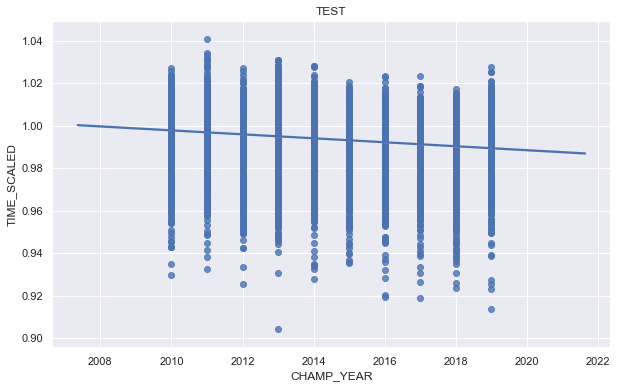

In [109]:
fig, ax = plt.subplots()
plot = sns.regplot(data = dfnot2021, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95).set_title('TEST')
# plot = sns.regplot(data = df2021_not_treat, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95, color='g')
# plot = sns.regplot(data = df2021_treat, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95, color='r')

plt.gcf().set_size_inches(10,6)

# add 2021 mean datapoint for treated and non-treated
plt.scatter(x=2021, y=df2021_not_treat.TIME_SCALED.mean(), color='g')
plt.scatter(x=2021, y=df2021_treat.TIME_SCALED.mean(), color='r')

In [110]:
# add column where each time_secs is normalized by the mean for that event in all years for each sex and division
group = df100.groupby(['SEX', 'DIVISION', 'EVENT', 'CHAMP_YEAR']).TIME_SECS

# divide each time in time_secs by the mean for it's group
# df100['NORM_TIME'] = df100['TIME_SECS'] / group.transform('mean')

In [111]:
test = []
for n, grp in df100.groupby(['SEX', 'DIVISION', 'EVENT']):
    cat = [[i,j] for i, j in zip(grp.CHAMP_YEAR, grp.TIME_SECS)]
    test.append(cat)

### Plot trend of TIME_SECS over time for each event grouped by sex and division

In [112]:
# function to convert seconds to time format
def convert_seconds(secs):
    '''Takes a total number of seconds and returns in %M:%S.%f format'''
    date = datetime.datetime.utcfromtimestamp(secs)
    output = datetime.datetime.strftime(date, "%M:%S.%f")
    return output

In [113]:
# handle a bit differently because men run 110H while women run 100H
men_running_events = ['100', '200', '400', '800', '1500', '5000', '10000',
       '110H', '400H', '3000S', '4x100', '4x400']
women_running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '400H', '3000S', '4x100', '4x400']

In [114]:
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100_not2021 = df100[df100['CHAMP_YEAR'] != 2021]

In [115]:
# summary stats for TIME_SECS running events
description = df100.groupby(['DIVISION', 'CHAMP_YEAR', 'EVENT', 'SEX'])['TIME_SECS'].describe(percentiles = [.2, .4, .6, .8])
description.sort_values(['DIVISION', 'CHAMP_YEAR', 'EVENT', 'SEX'], ascending=[True, False, True, True], inplace=True)

In [116]:
description

count         mean        std      min  \
DIVISION CHAMP_YEAR EVENT SEX                                             
D1       2019       100   Men     24.0    10.077500   0.068857     9.94   
                          Women   24.0    11.171667   0.099287    10.96   
                    10000 Men     24.0  1716.243750  14.725814  1691.30   
                          Women   24.0  1973.504167  27.121790  1926.71   
                    100H  Women   24.0    12.919167   0.158084    12.55   
                    110H  Men     24.0    13.596250   0.197414    13.07   
                    1500  Men     24.0   220.079583   1.707988   217.20   
                          Women   24.0   254.791250   1.335483   252.08   
                    200   Men     24.0    20.333333   0.177658    19.76   
                          Women   24.0    22.814167   0.161969    22.52   
                    3000S Men     24.0   522.082083   5.647451   507.90   
                          Women   24.0   598.738750   7.151741   585.66   
                    400   Men     24.0    45.527500   0.445248    44.38   
                          Women   24.0    51.870417   0.495216    50.96   
                    400H  Men     24.0    50.094167   0.462065    49.09   
                          Women   24.0    57.340417   0.508882    56.11   
                    4x100 Men     24.0    39.078750   0.310067    38.41   
                          Women   24.0    43.427500   0.428397    42.44   
                    4x400 Men     24.0   184.064167   1.173504   181.77   
                          Women   24.0   211.348333   1.815663   207.53   
                    5000  Men     24.0   816.200000   4.888360   805.06   
                          Women   24.0   940.887917   6.917875   923.46   
                    800   Men     24.0   107.136667   0.905090   104.76   
                          Women   24.0   123.965417   0.736584   122.41   
         2018       100   Men     24.0    10.095417   0.051834     9.99   
                          Women   24.0    11.085000   0.100564    10.86   
                    10000 Men     24.0  1723.395833  19.358847  1684.44   
                          Women   24.0  1983.631250  27.619523  1920.55   
                    100H  Women   24.0    12.852917   0.165095    12.40   
                    110H  Men     24.0    13.576250   0.162583    13.15   
...                                ...          ...        ...      ...   
D3       2011       4x400 Men     24.0   194.127083   1.125269   190.66   
                          Women   24.0   230.125000   3.145454   220.41   
                    5000  Men     24.0   868.934583   6.586412   855.79   
                          Women   24.0  1028.092917   8.158471  1009.42   
                    800   Men     24.0   111.156667   1.007794   108.71   
                          Women   24.0   131.489167   1.471521   126.83   
         2010       100   Men     24.0    10.667083   0.109564    10.40   
                          Women   24.0    12.117917   0.112905    11.94   
                    10000 Men     24.0  1833.646667  22.182317  1785.02   
                          Women   24.0  2162.166250  21.842403  2112.04   
                    100H  Women   24.0    14.577500   0.295006    13.99   
                    110H  Men     24.0    14.600417   0.150636    14.32   
                    1500  Men     24.0   231.064167   1.369833   228.40   
                          Women   24.0   271.765000   3.062244   265.43   
                    200   Men     24.0    21.502500   0.221816    20.82   
                          Women   24.0    24.828750   0.260823    24.33   
                    3000S Men     24.0   549.830417   2.676598   545.24   
                          Women   24.0   647.067500  11.320761   622.32   
                    400   Men     24.0    48.061667   0.333775    47.13   
                          Women   24.0    56.308750   0.485506    55.06   
                    400H  Men     24.0    53.078333   0.79

# Visualizations

In [117]:
# queried list of dfs, one for each year

def query_each_year(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = []
    for year in df.CHAMP_YEAR.unique():
        new_df = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
        results.append(new_df)
    return results

In [118]:
# use queried list of dfs for each year to create a histogram for each year

def histograms_each_year(df, division, sex, event):
    '''Creates a histogram for each df in df_list after query constraints'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        fig, ax = plt.subplots()
        plot = df.TIME_SECS.plot(kind='hist', bins=15, ax=ax)
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.gcf().set_size_inches(8,5)
        pl.suptitle(str(df.CHAMP_YEAR.iloc[0]) + ' ' + df.SEX.iloc[0] + '\'s ' + df.EVENT.iloc[0])

### Example: lets make histograms for D1 men's 1500

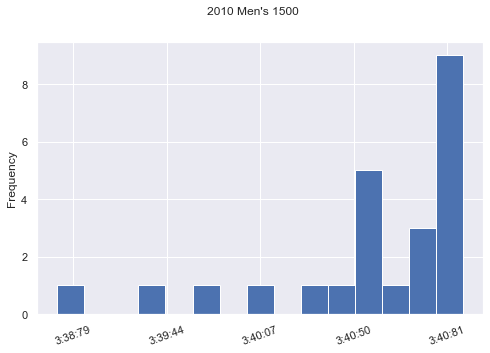

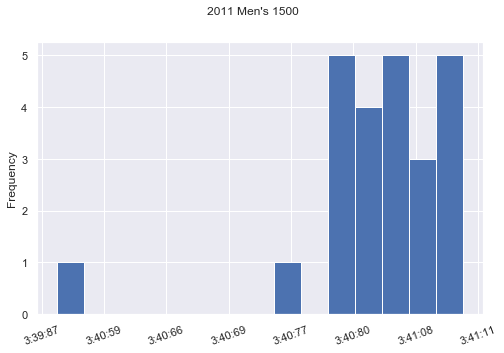

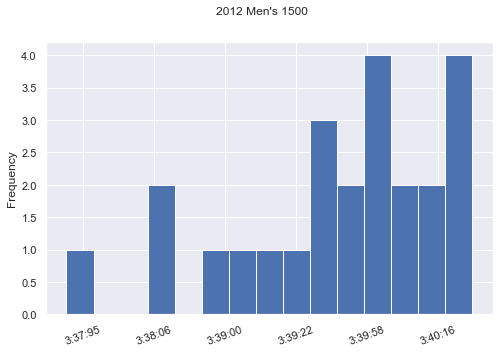

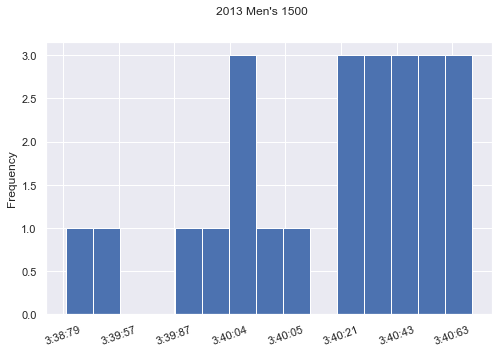

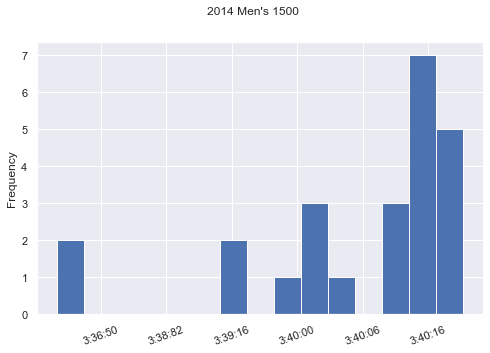

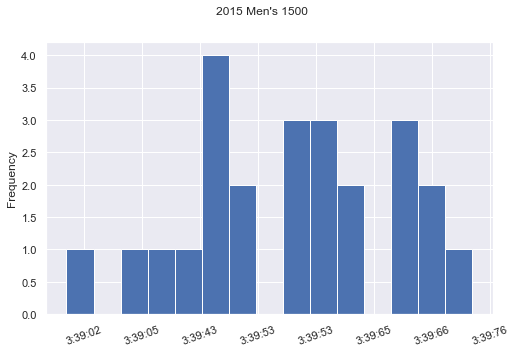

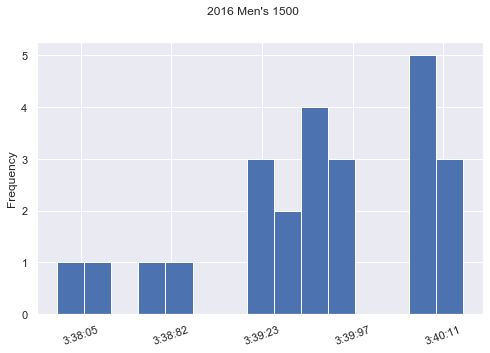

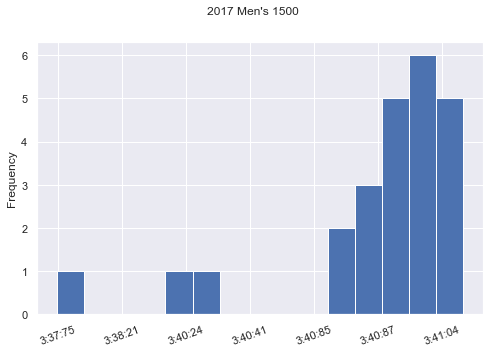

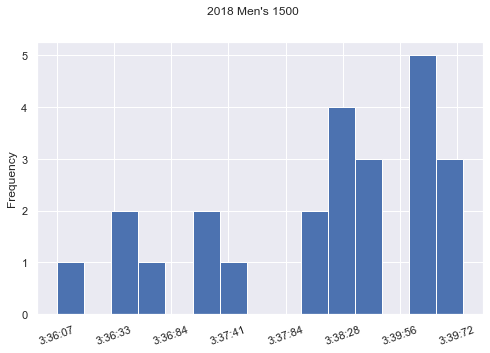

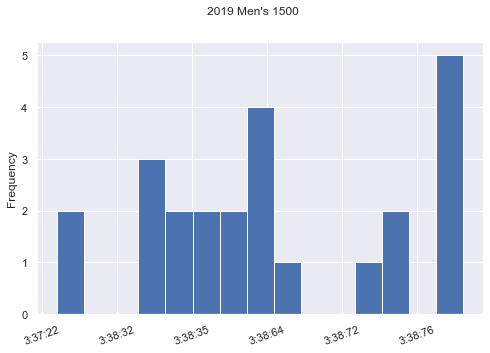

In [119]:
histograms_each_year(df100, 'D1', 'Men', '1500')

In [120]:
def hist_density_overlap(df, division, sex, event):
    '''Creates an overlapping histogram and density for each df in queried list of dfs for each year'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        plot = sns.distplot(df.TIME_SECS, kde=True, bins=15, hist=True, label=df.CHAMP_YEAR.iloc[0])
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.legend()
        plt.gcf().set_size_inches(20,12)
        pl.suptitle(division + ' ' + sex + '\'s ' + event)

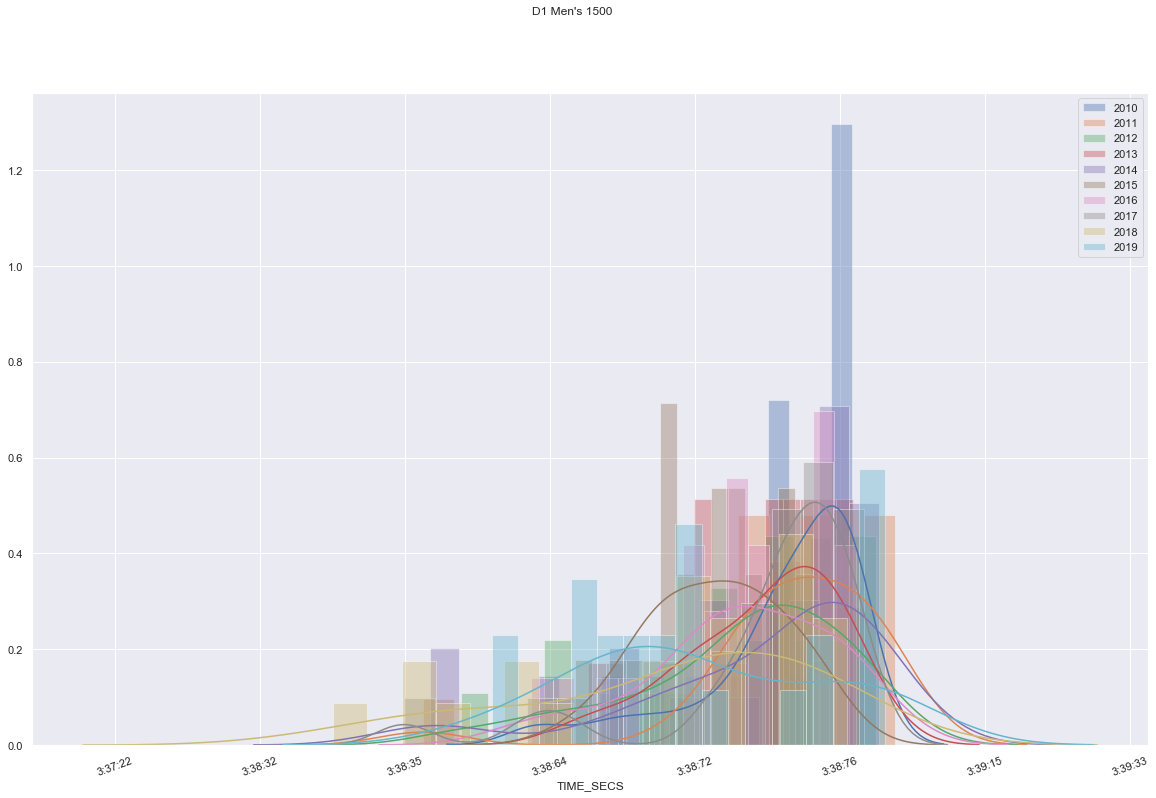

In [121]:
hist_density_overlap(df100, 'D1', 'Men', '1500')

### Take a look at combined distribution across all years for each event division and sex

In [122]:
# queried df, all years, for specified division sex event and 

def query_all_years(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = df[(df['CHAMP_YEAR'] != 2021) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
    return results

In [123]:
# histogram for results for given division, sex, event and all years

def histogram_all_years(df, division, sex, event):
    '''Takes a queried dataframe and combines all TIME_SECS for that given division sex and event across all years'''
    
    df_graph = query_all_years(df, division, sex, event)
    
    fig, ax = plt.subplots()
    plot = df_graph.TIME_SECS.plot(kind='hist', bins=15, grid=True, ax=ax)
    plot = plot.set_xticklabels(df_graph['TIME'], rotation=20)
    pl.suptitle(str(df_graph.DIVISION.iloc[0] + ' ' + df_graph.SEX.iloc[0] + '\'s ' + df_graph.EVENT.iloc[0]))

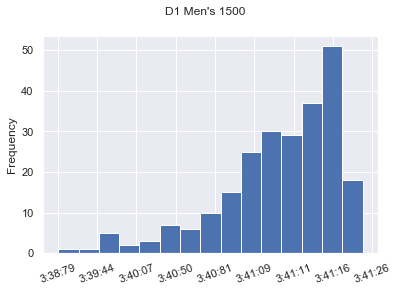

In [124]:
histogram_all_years(df100, 'D1', 'Men', '1500')

### Function that creates a dataframe with 
### min, average, median, max, std, and quintiles for TIME_SECS for each event across ALL years, division, sex, event

In [125]:
def events_desc(df, division, sex):
    '''Returns a dataframe with summary stats for TIME_SECS for each event for all years given division and sex'''
    series_list = []
    for event in df.EVENT.unique():
        df_desc = df[(df['DIVISION'] == division) & (df100['SEX'] == sex) & (df100['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])
        series_list.append(df_desc)
    result = pd.DataFrame(series_list, index=df100.EVENT.unique())
    return result

In [126]:
D2women_desc = events_desc(df100, 'D3', 'Women')
D2women_desc.head()

,count,mean,std,min,20%,40%,50%,60%,80%,max
100,240.0,12.016750,0.140696,11.41,11.938,12.000,12.03,12.060,12.130,12.32
10000,240.0,2151.882875,30.667254,2024.06,2131.024,2150.556,2158.00,2164.062,2176.416,2202.20
100H,240.0,14.378250,0.210871,13.64,14.208,14.350,14.41,14.450,14.540,14.89
110H,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500,240.0,271.145542,3.238117,255.77,268.882,271.090,271.71,272.280,273.470,276.51


### Lets look at descriptive statistics for TIME_SECS and do some statistical hypothesis testing. 

In [127]:
event_means = df100.groupby(['CHAMP_YEAR', 'DIVISION', 'SEX', 'EVENT']).TIME_SECS.mean()
event_means.head()

CHAMP_YEAR  DIVISION  SEX  EVENT
2010        D1        Men  100        10.191250
                           10000    1721.702083
                           110H       13.682500
                           1500      221.196667
                           200        20.593333
Name: TIME_SECS, dtype: float64

In [150]:
# mean for event in 2021
def mean_event_2021(division, sex, event):
    '''Returns the averagze TIME_SECS for given division sex and event in year 2021'''
    return df100_2021[(df100_2021['DIVISION'] == division) & (df100_2021['SEX'] == sex) & (df100_2021['EVENT'] == event)].TIME_SECS.mean()

In [151]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    return result

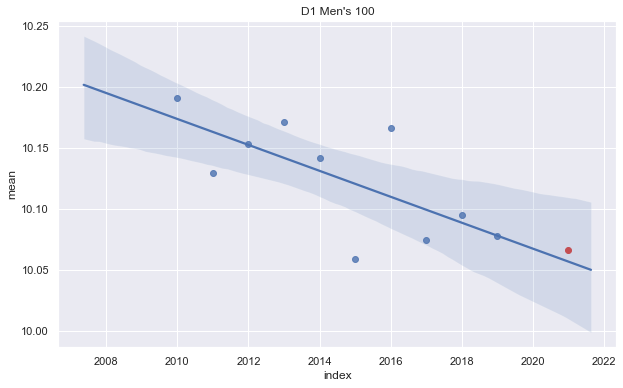

In [152]:
df_descD1men1500 = event_desc_each_year(df100, 'D1', 'Men', '100')

### Take a look at every event for a given division and sex.

In [153]:
def regplots(division, sex):
    '''Create a regplot for 2019 mean times in blue and 2021 mean in red for given division and sex'''
    for event in df100.EVENT.unique():
        if sex == 'Men':
            if event in men_running_events:
                event_desc_each_year(df100_not2021, division, sex, event)
        else: 
            if event in women_running_events:
                event_desc_each_year(df100_not2021, division, sex, event)

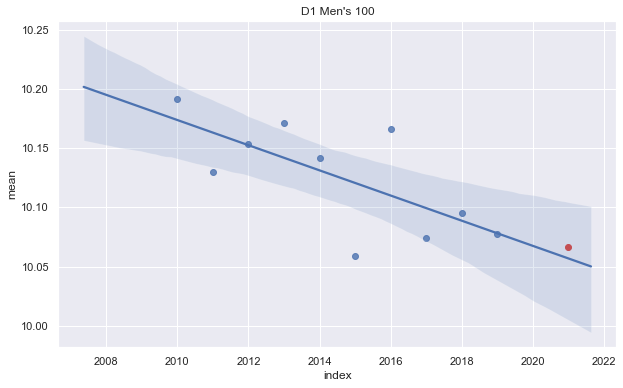

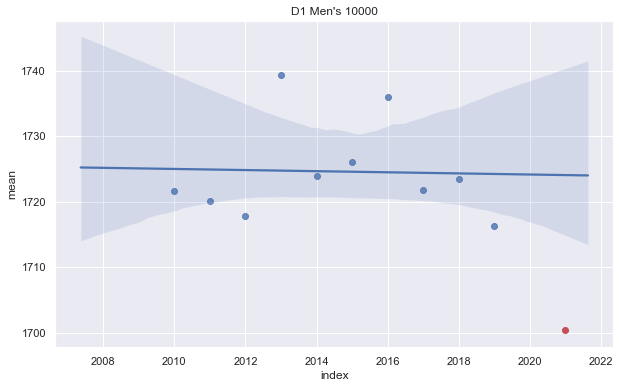

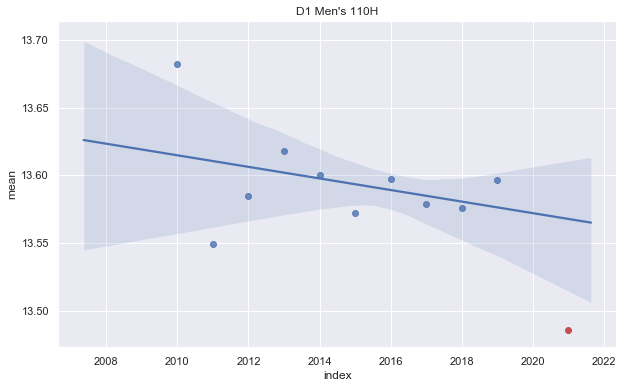

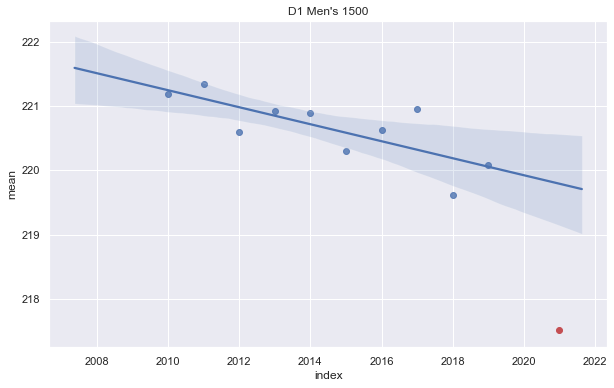

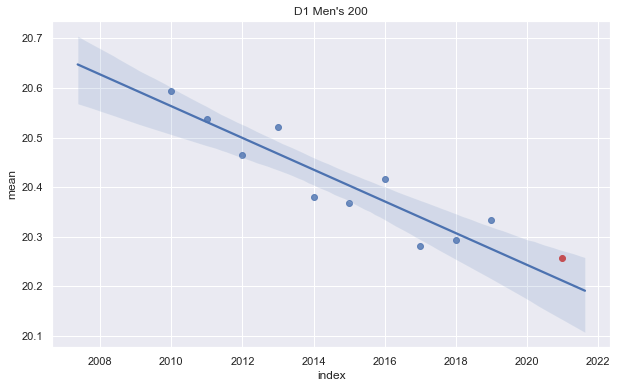

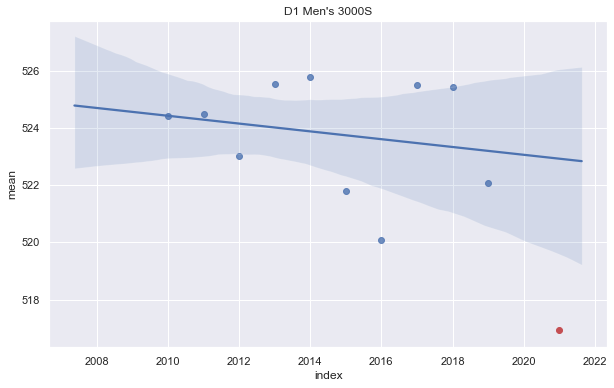

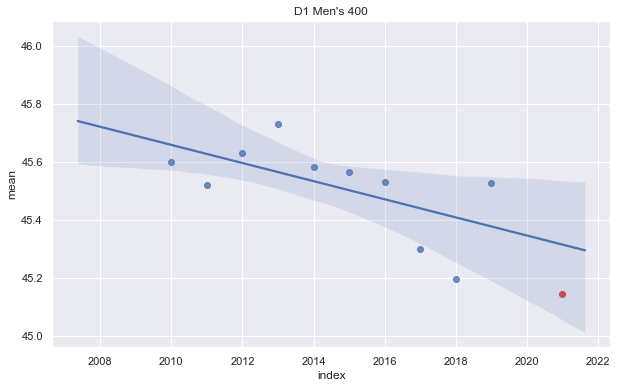

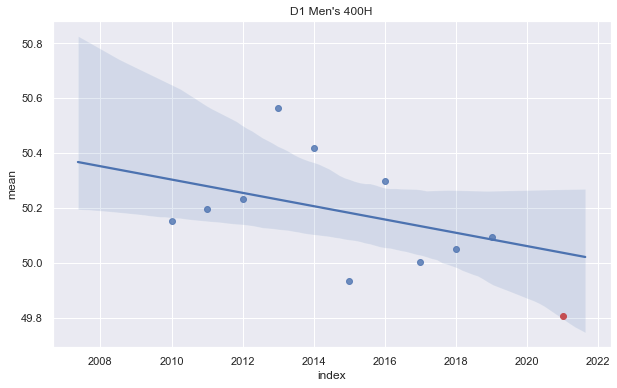

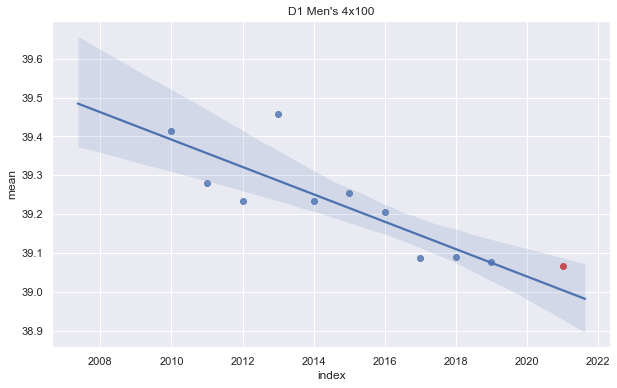

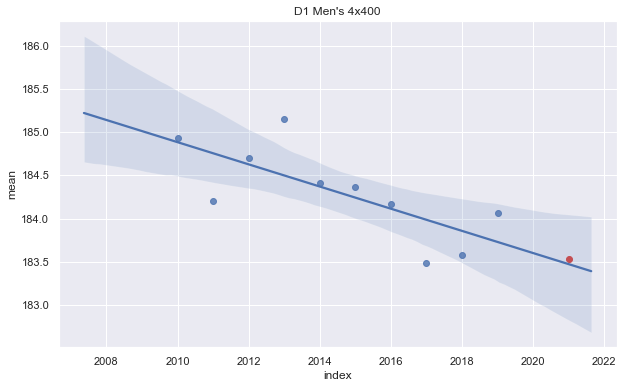

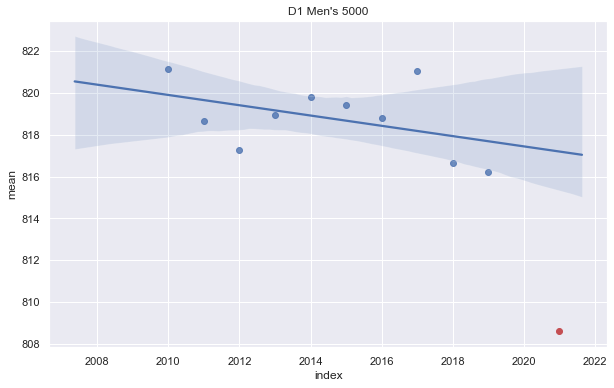

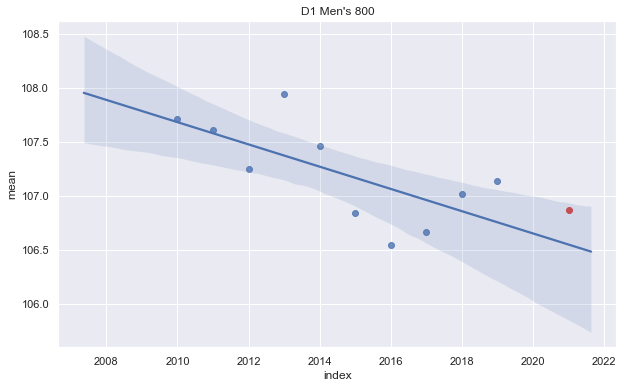

In [154]:
d1men = regplots('D1', 'Men')

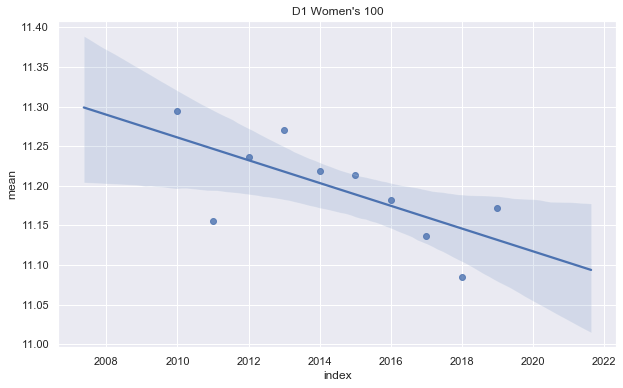

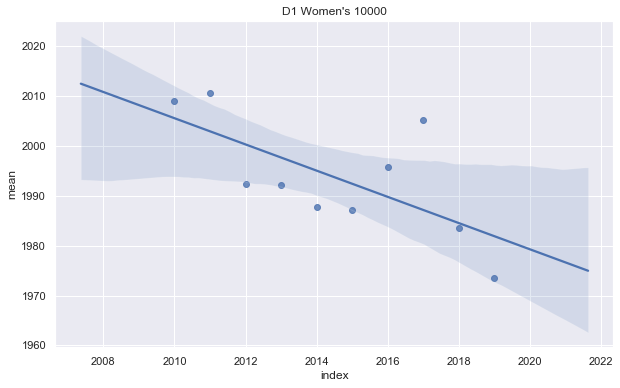

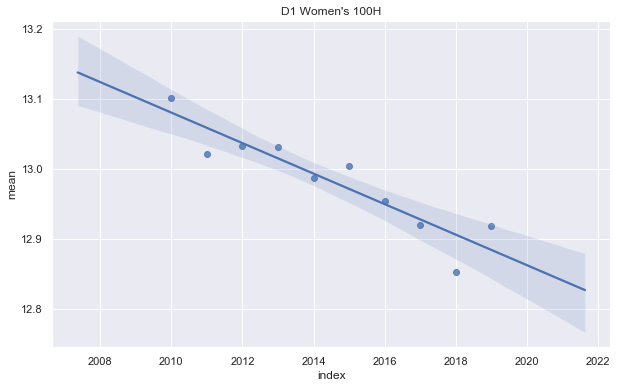

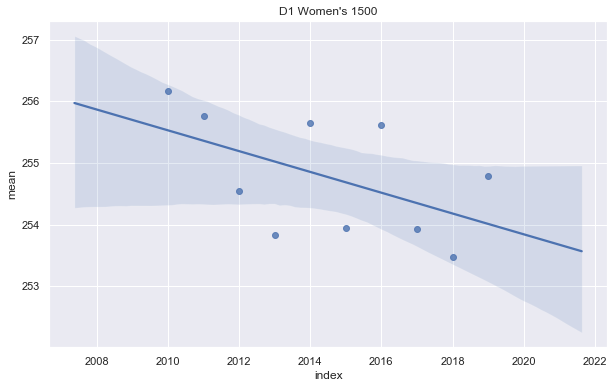

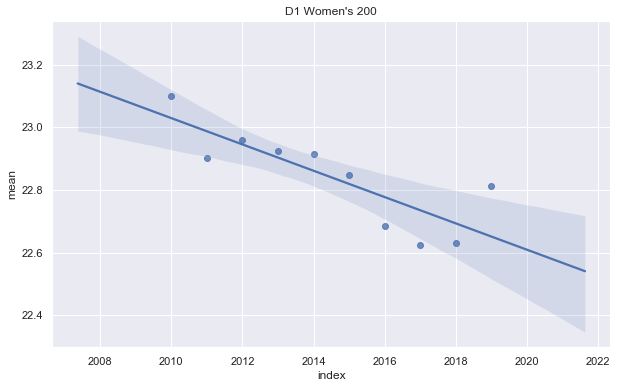

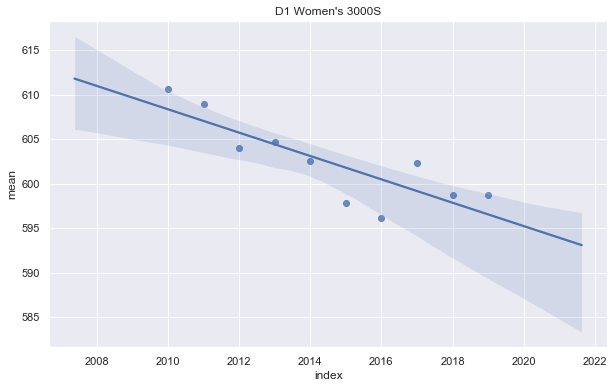

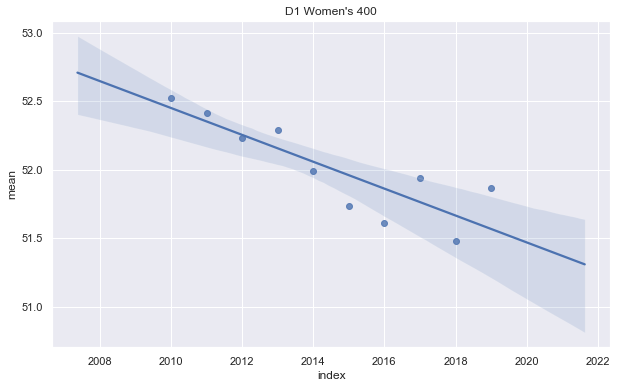

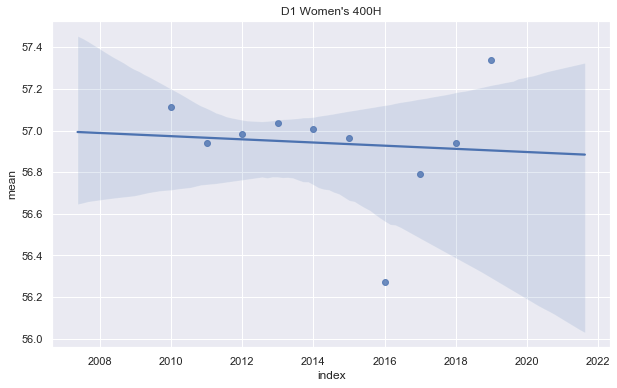

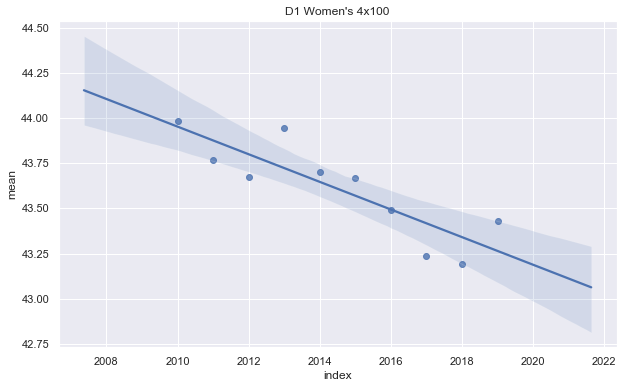

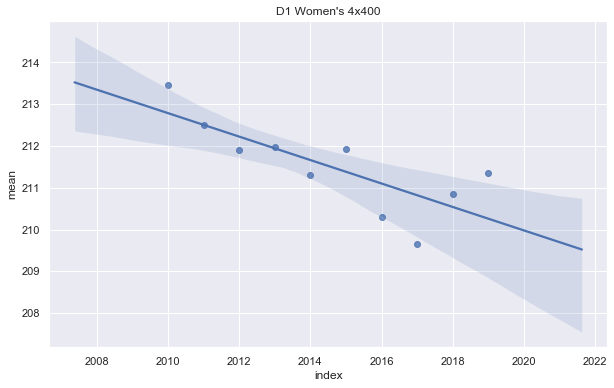

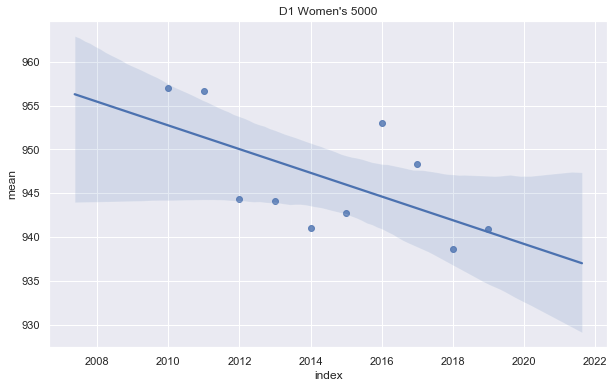

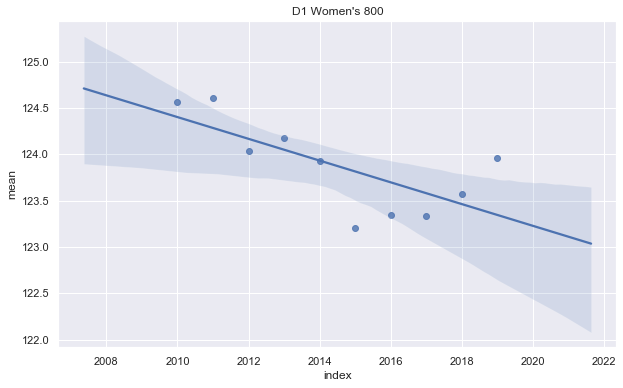

In [133]:
d1women = regplots('D1', 'Women')

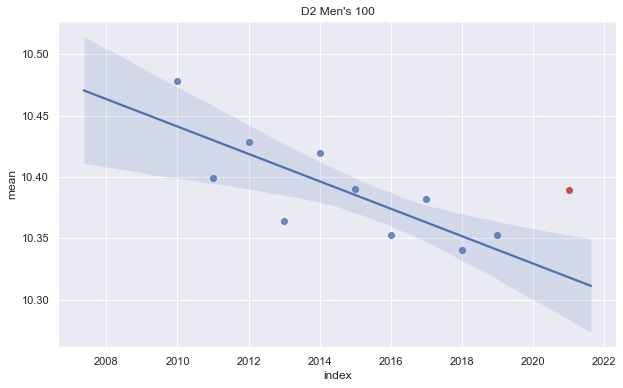

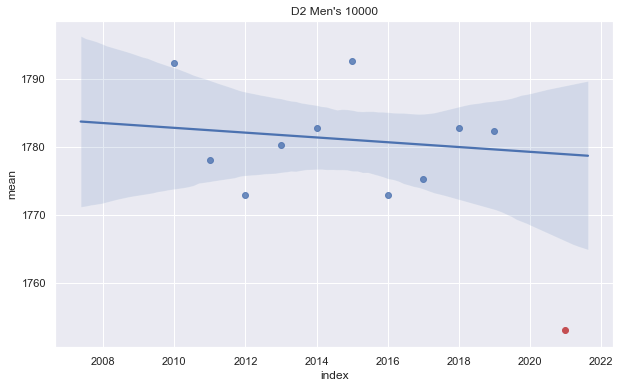

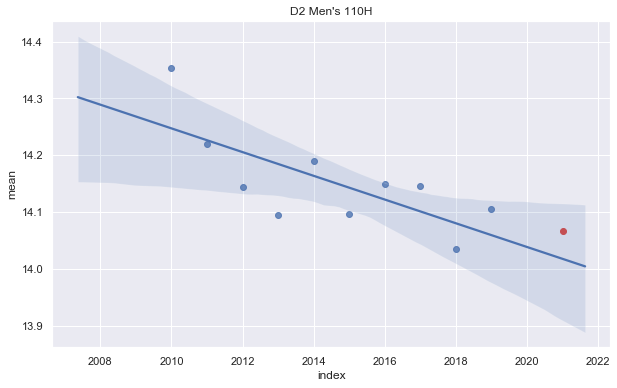

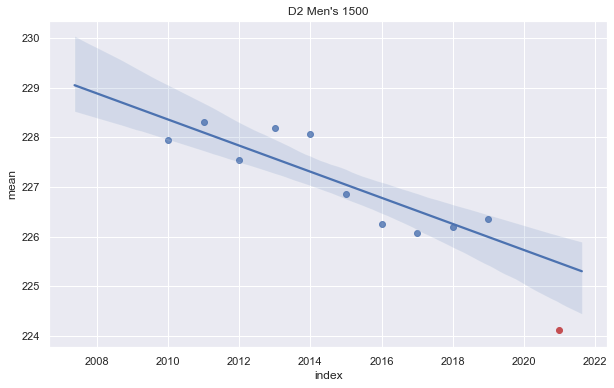

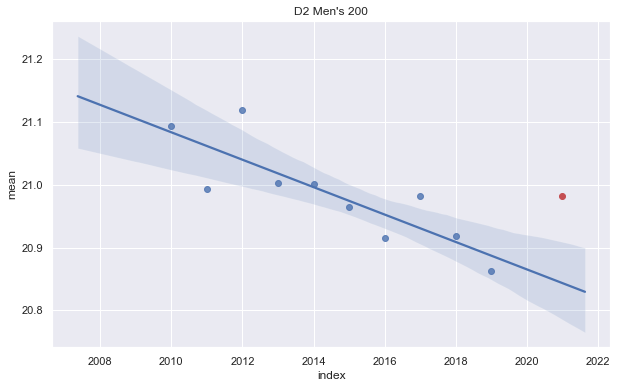

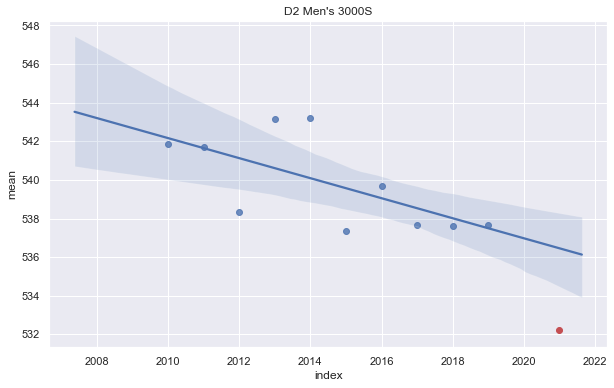

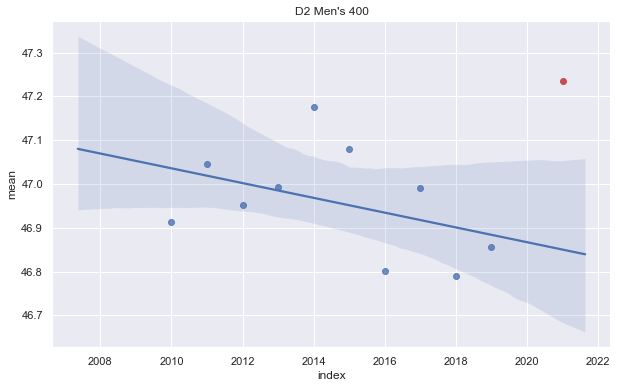

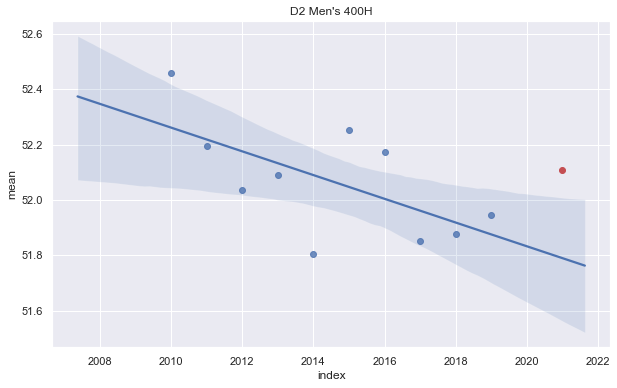

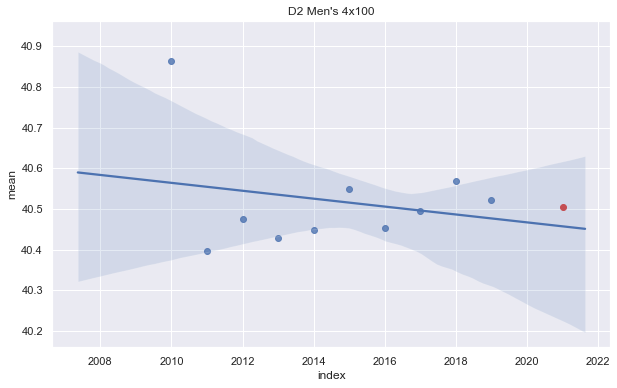

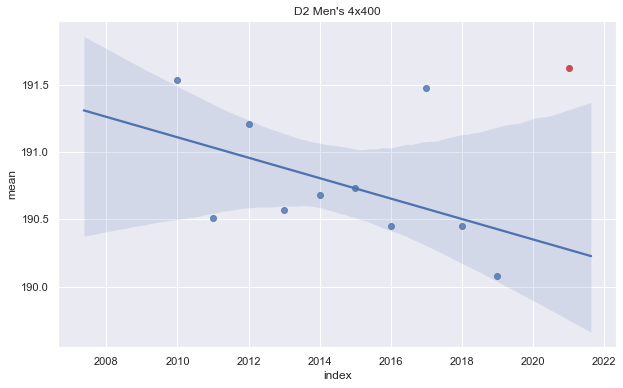

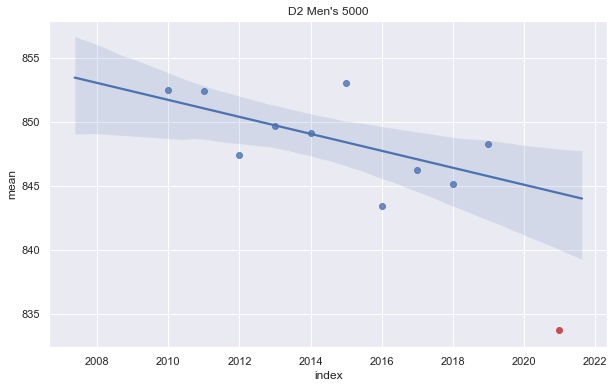

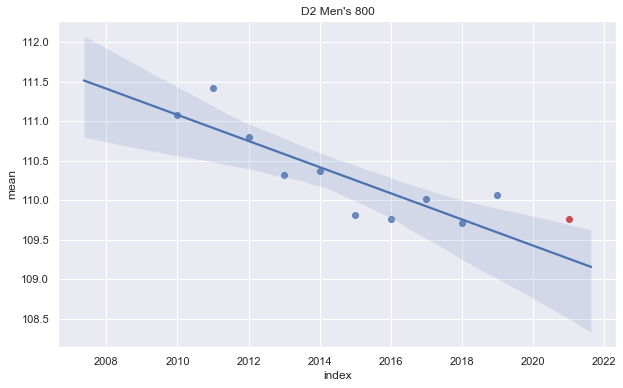

In [155]:
d2men = regplots('D2', 'Men')

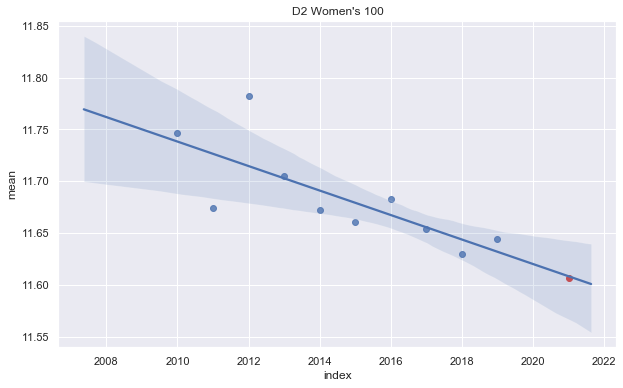

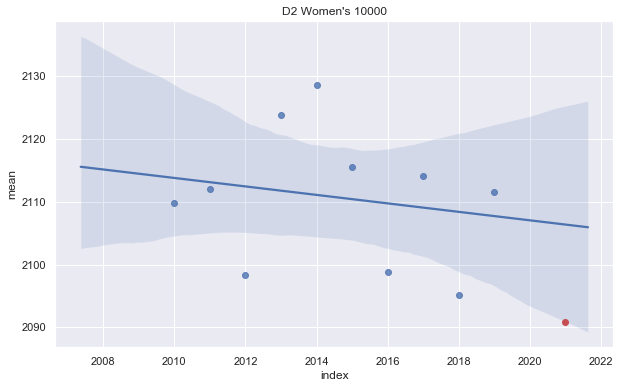

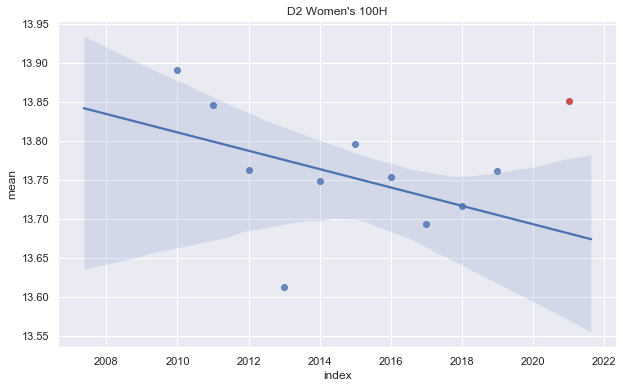

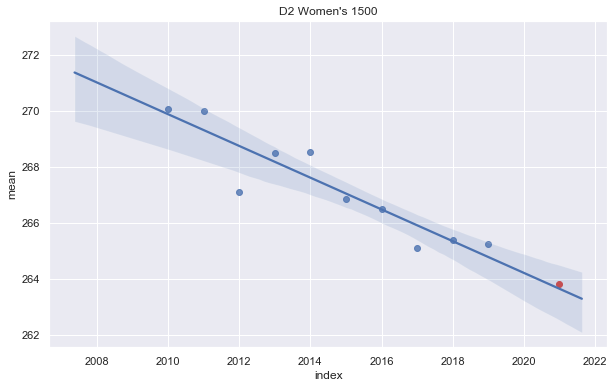

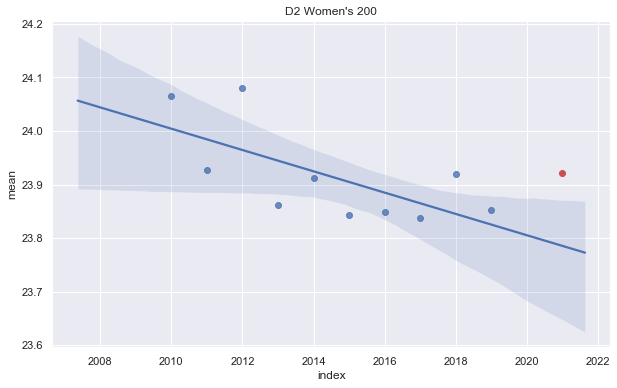

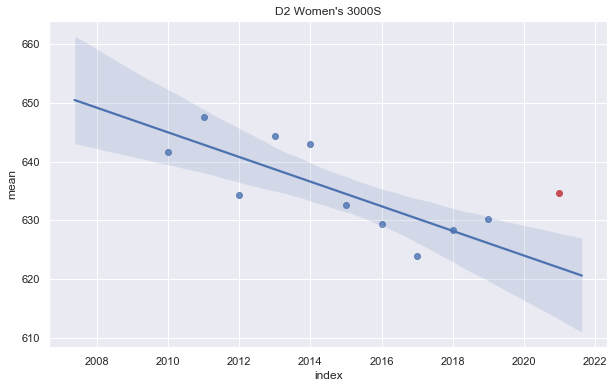

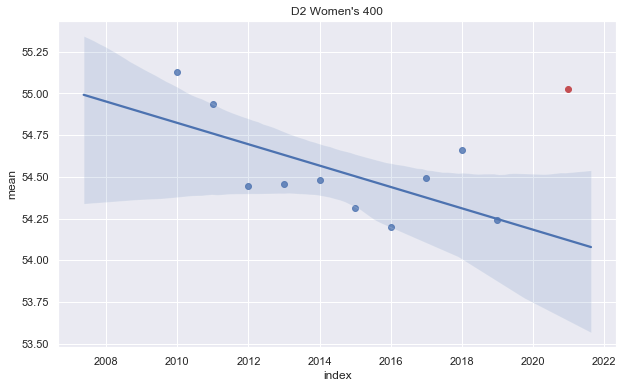

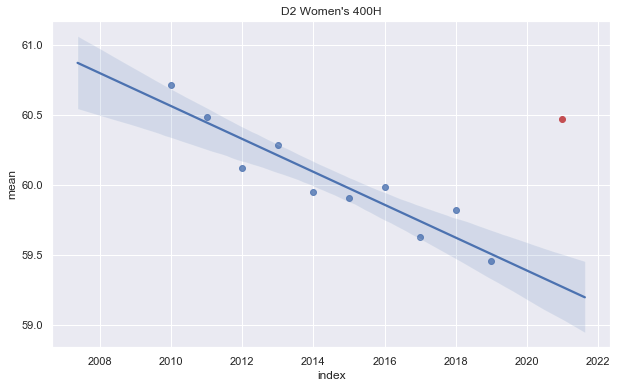

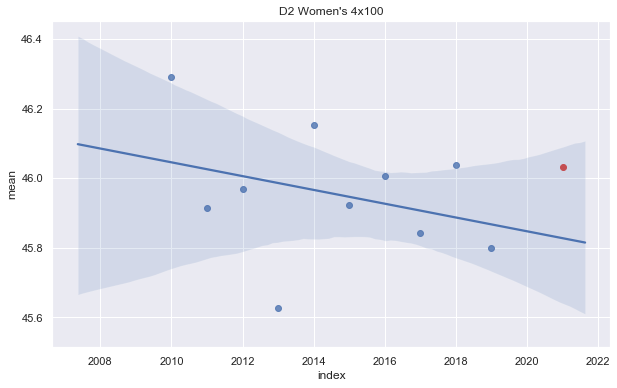

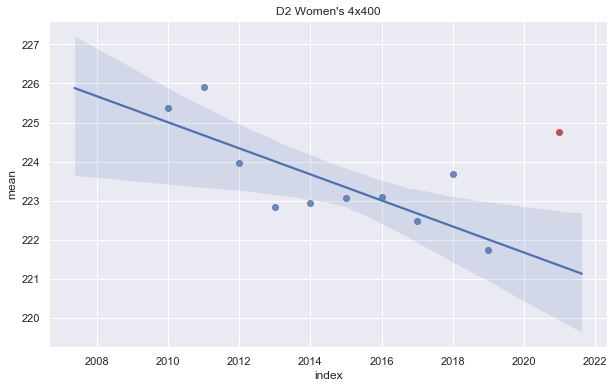

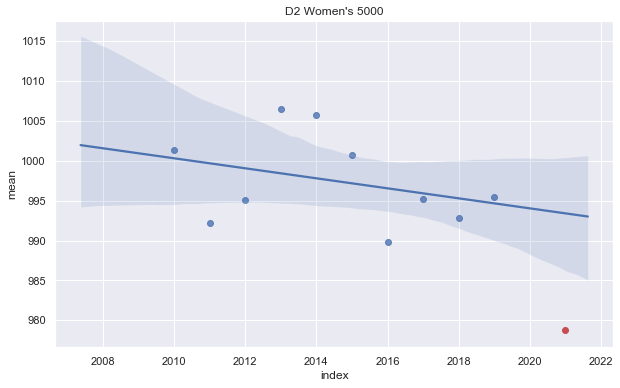

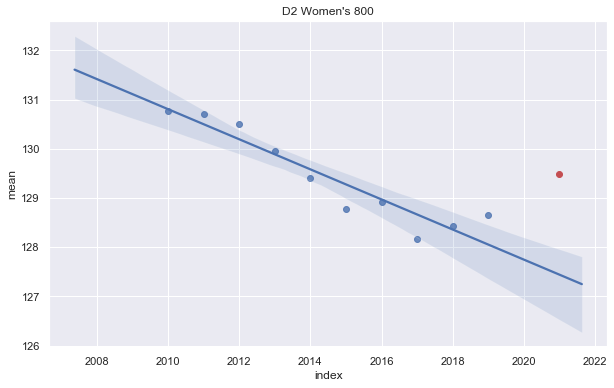

In [156]:
d2women = regplots('D2', 'Women')

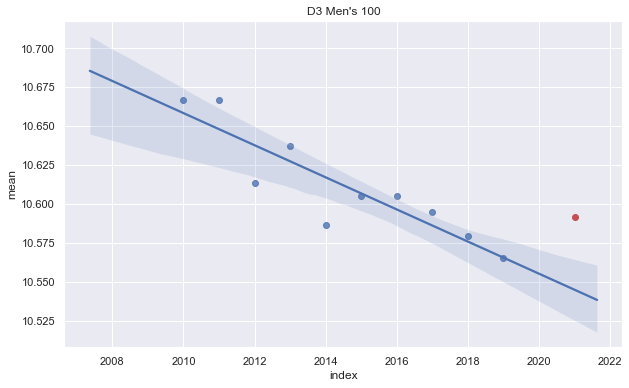

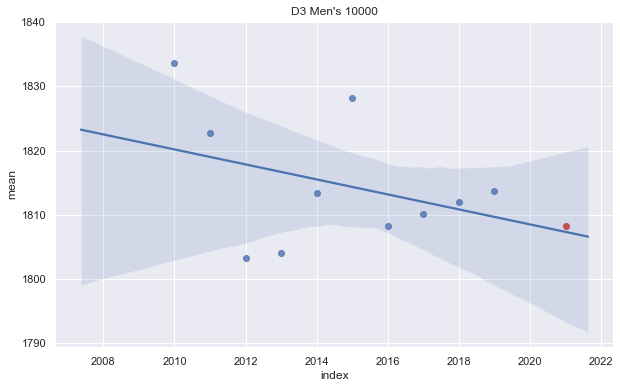

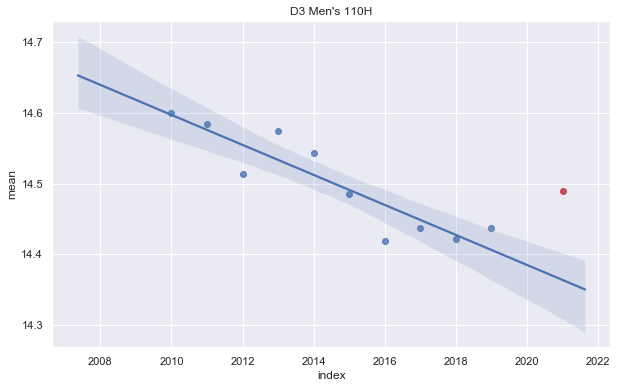

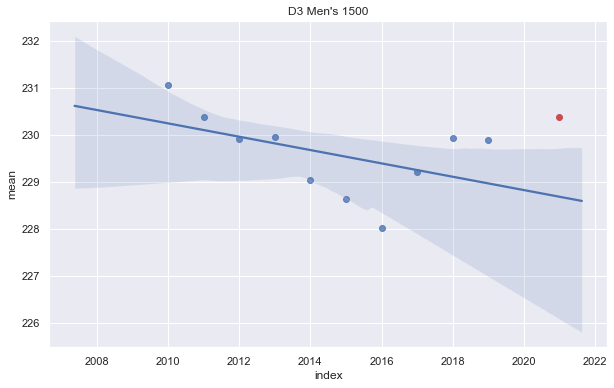

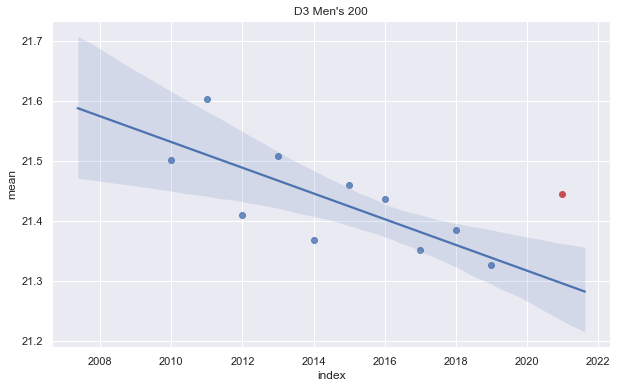

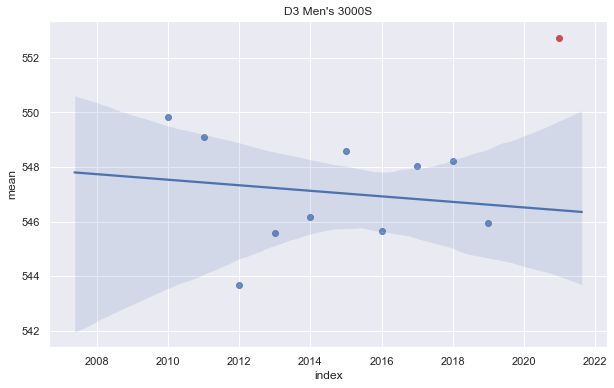

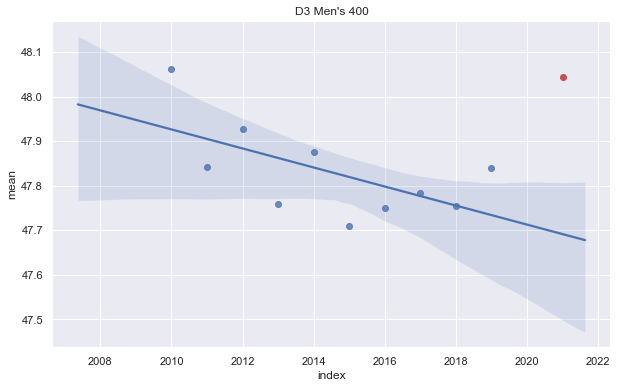

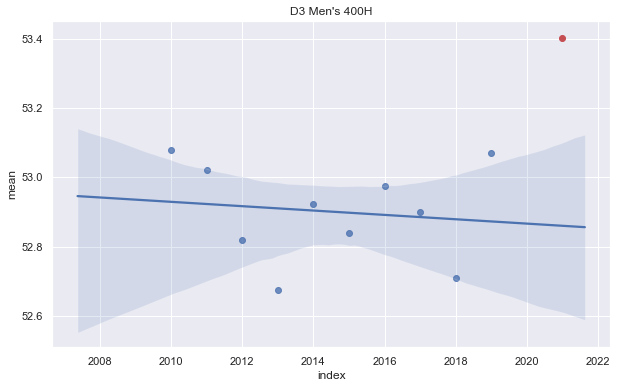

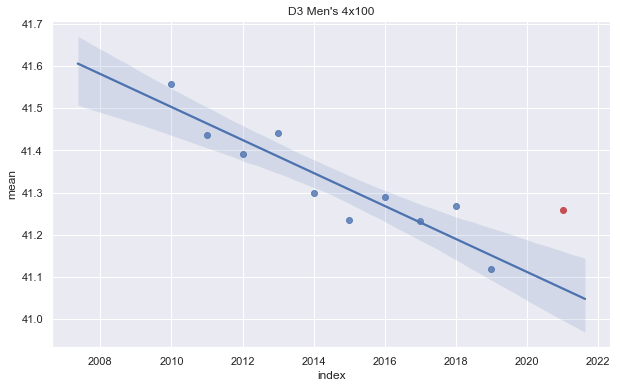

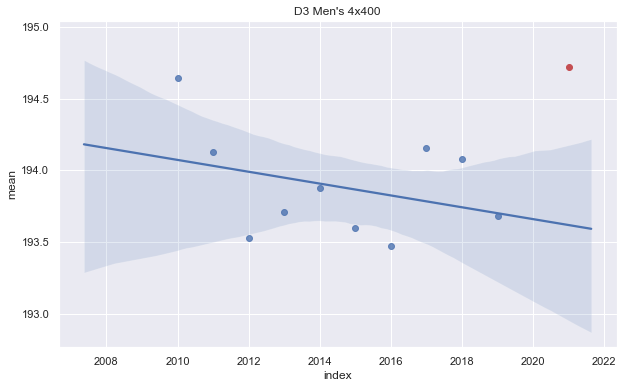

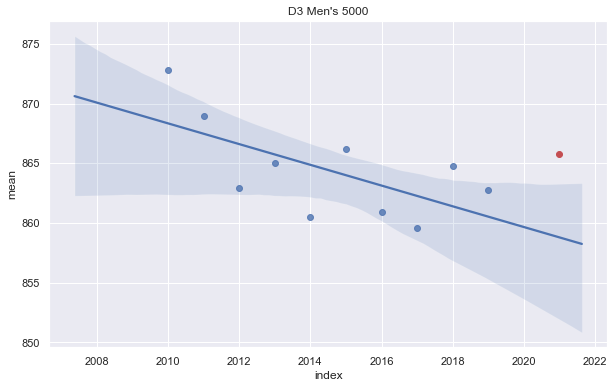

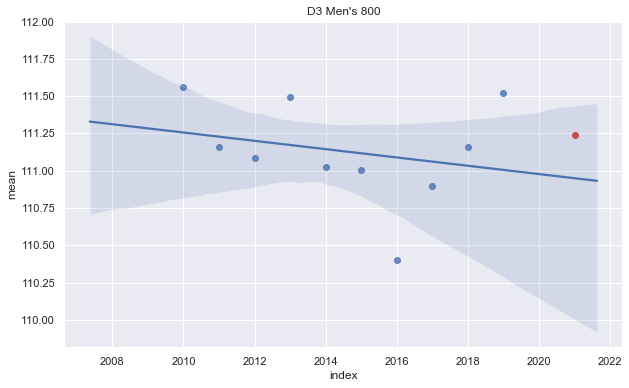

In [157]:
d3men = regplots('D3', 'Men')

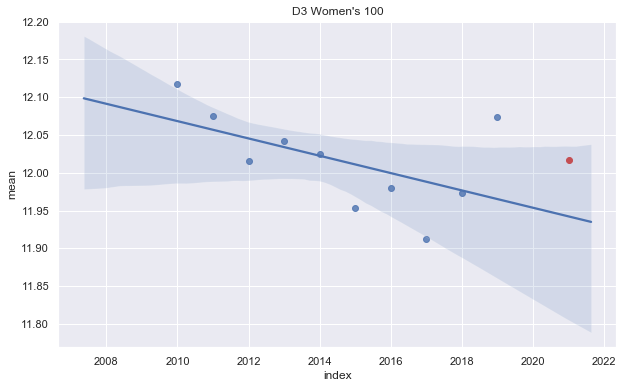

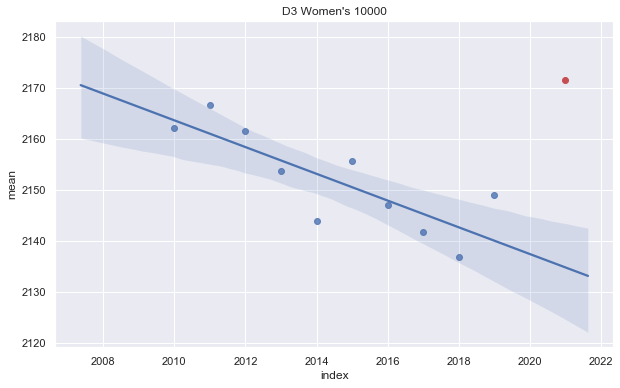

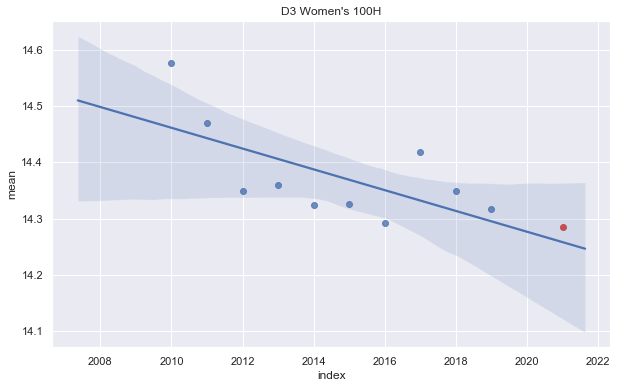

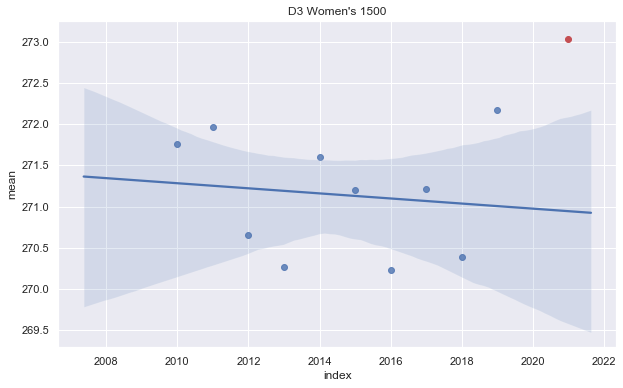

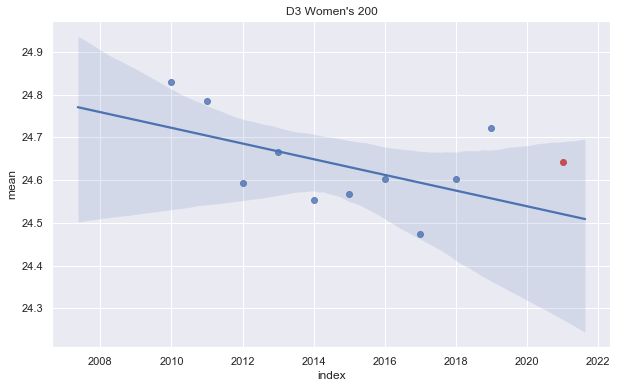

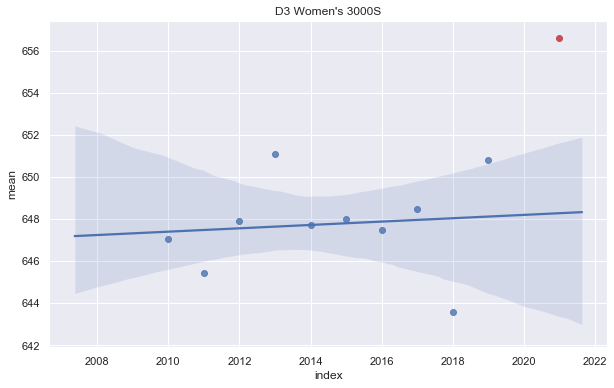

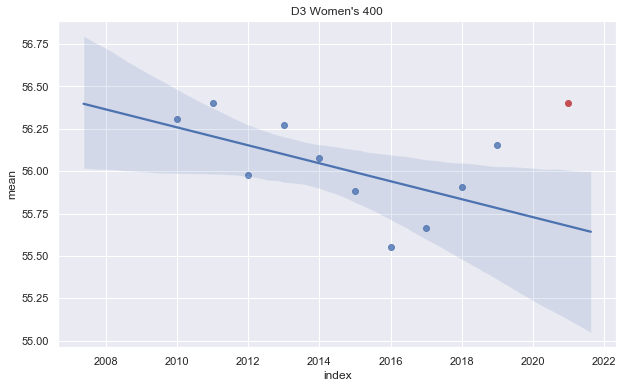

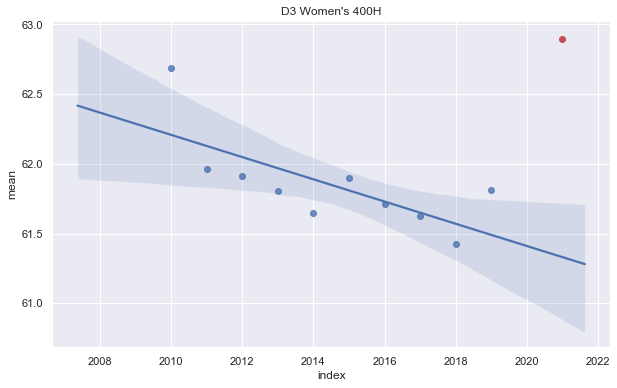

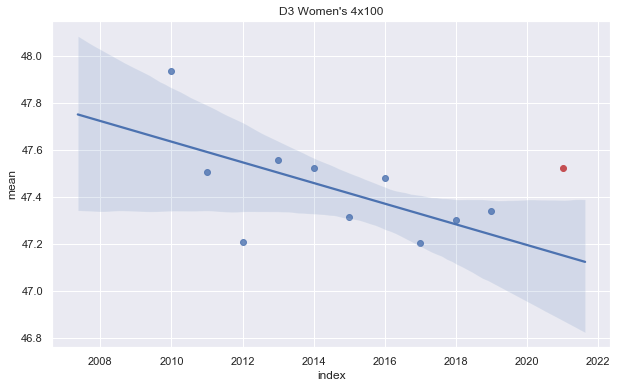

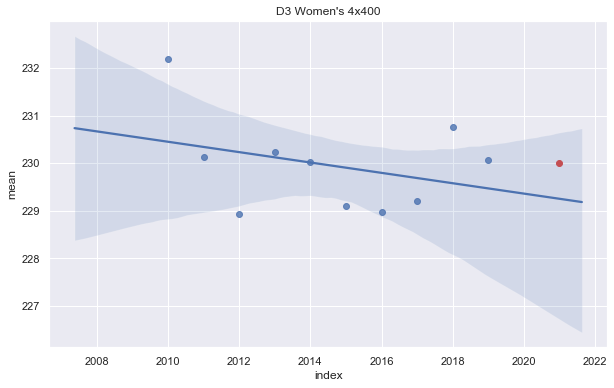

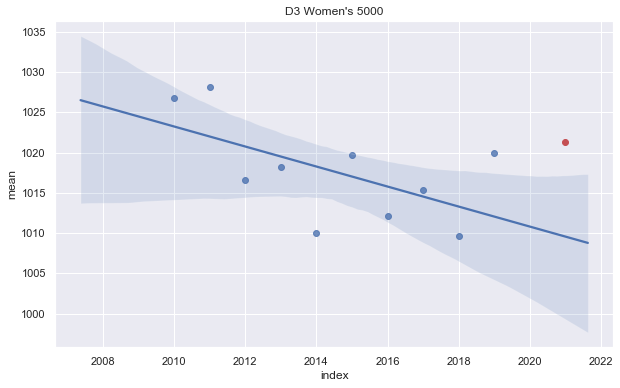

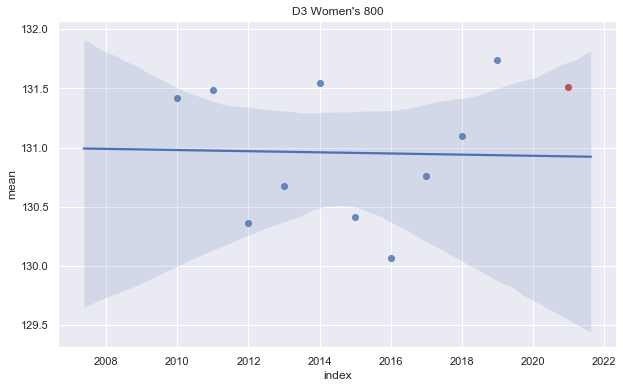

In [158]:
d3women = regplots('D3', 'Women')

### Make DF with mean time for each year by group (DIVISION/EVENT/SEX)

In [38]:
df_list = [g for _,g in df100.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX'])]

In [63]:
means_list = [[i.iloc[0].CHAMP_YEAR, i.iloc[0].DIVISION, i.iloc[0].SEX, i.iloc[0].EVENT, i.TIME_SECS.mean()] for i in df_list]

In [77]:
groups = [means_list[i][1:4] for i in range(len(means_list))]

In [78]:
unique_groups = [item for index, item in enumerate(groups) if item not in groups[:index]]

In [88]:
unique_groups_flatten = [''.join(i) for i in unique_groups]

In [124]:
for name in unique_groups_flatten:
    exec('{} = pd.DataFrame()'.format(name))

In [111]:
means_list[0]

[2010, 'D1', 'Men', '100', 10.375700000000004]

In [ ]:
# histogram for results for given division, sex, event and all years

def histogram_all_years_NORM(df, division, sex, event):
    '''Takes a queried dataframe and combines all NORM_TIME for that given division sex and event across all years'''
    
    df_graph = query_all_years(df, division, sex, event)
    
    fig, ax = plt.subplots()
    plot = df_graph.NORM_TIME.plot(kind='hist', bins=15, grid=True, ax=ax)
    plt.xlabel('TIME_SECS / MEAN')
    pl.suptitle(str(df_graph.DIVISION.iloc[0] + ' ' + df_graph.SEX.iloc[0] + '\'s ' + df_graph.EVENT.iloc[0]))

In [ ]:
histogram_all_years_NORM(df100, 'D1', 'Men', '1500')

In [ ]:
# split off 2021 out into a separate dfs
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100_not2021 = df100[df100['CHAMP_YEAR'] != 2021]

In [ ]:
df100_2021.head()

In [ ]:
df100_not2021.CHAMP_YEAR.unique()

In [ ]:
means = [(year, df100_not2021[(df100_not2021['CHAMP_YEAR'] == year) & (df100_not2021['DIVISION'] == 'D1') & (df100_not2021['SEX'] == 'Men') & (df100_not2021['EVENT'] == '1500')].NORM_TIME.mean()) for year in df100_not2021.CHAMP_YEAR.unique()]

In [ ]:
means

In [ ]:
mean_2021 = df100_not2021[(df100_not2021['DIVISION'] == 'D1') & (df100_not2021['SEX'] == 'Men') & (df100_not2021['EVENT'] == '1500')].NORM_TIME.mean()

In [ ]:
plot = plt.scatter(*zip(*means))
plot = plt.scatter(x=2021, y=mean_2021, color='r')

### DUMMIES for fixed effects

In [ ]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100['DIVISION'])
event_dummy = pd.get_dummies(df100['EVENT'])
sex_dummy = pd.get_dummies(df100['SEX'])

In [ ]:
# concat dummy dfs to right side of df100
df100 = pd.concat([df100, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

In [ ]:
dftest = df100.copy(deep=False)

### Specify Model

In [ ]:
model = 'NORM_TIME ~ DISTANCE + AFTER2021 + DISTANCE * AFTER2021 + CHAMP_YEAR + DIVISION + SEX'

In [ ]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=dftest)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': dftest['CHAMP_YEAR']},use_t=True)
print(res.summary())